In [1]:
# !pip3 install --force-reinstall -v "protobuf==3.20.3"
# !pip install protobuf==3.20.3
import re

from transformers import DonutProcessor, VisionEncoderDecoderModel

import torch
from PIL import Image

In [2]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [3]:
task_prompt = "<s_cord-v2>"

decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

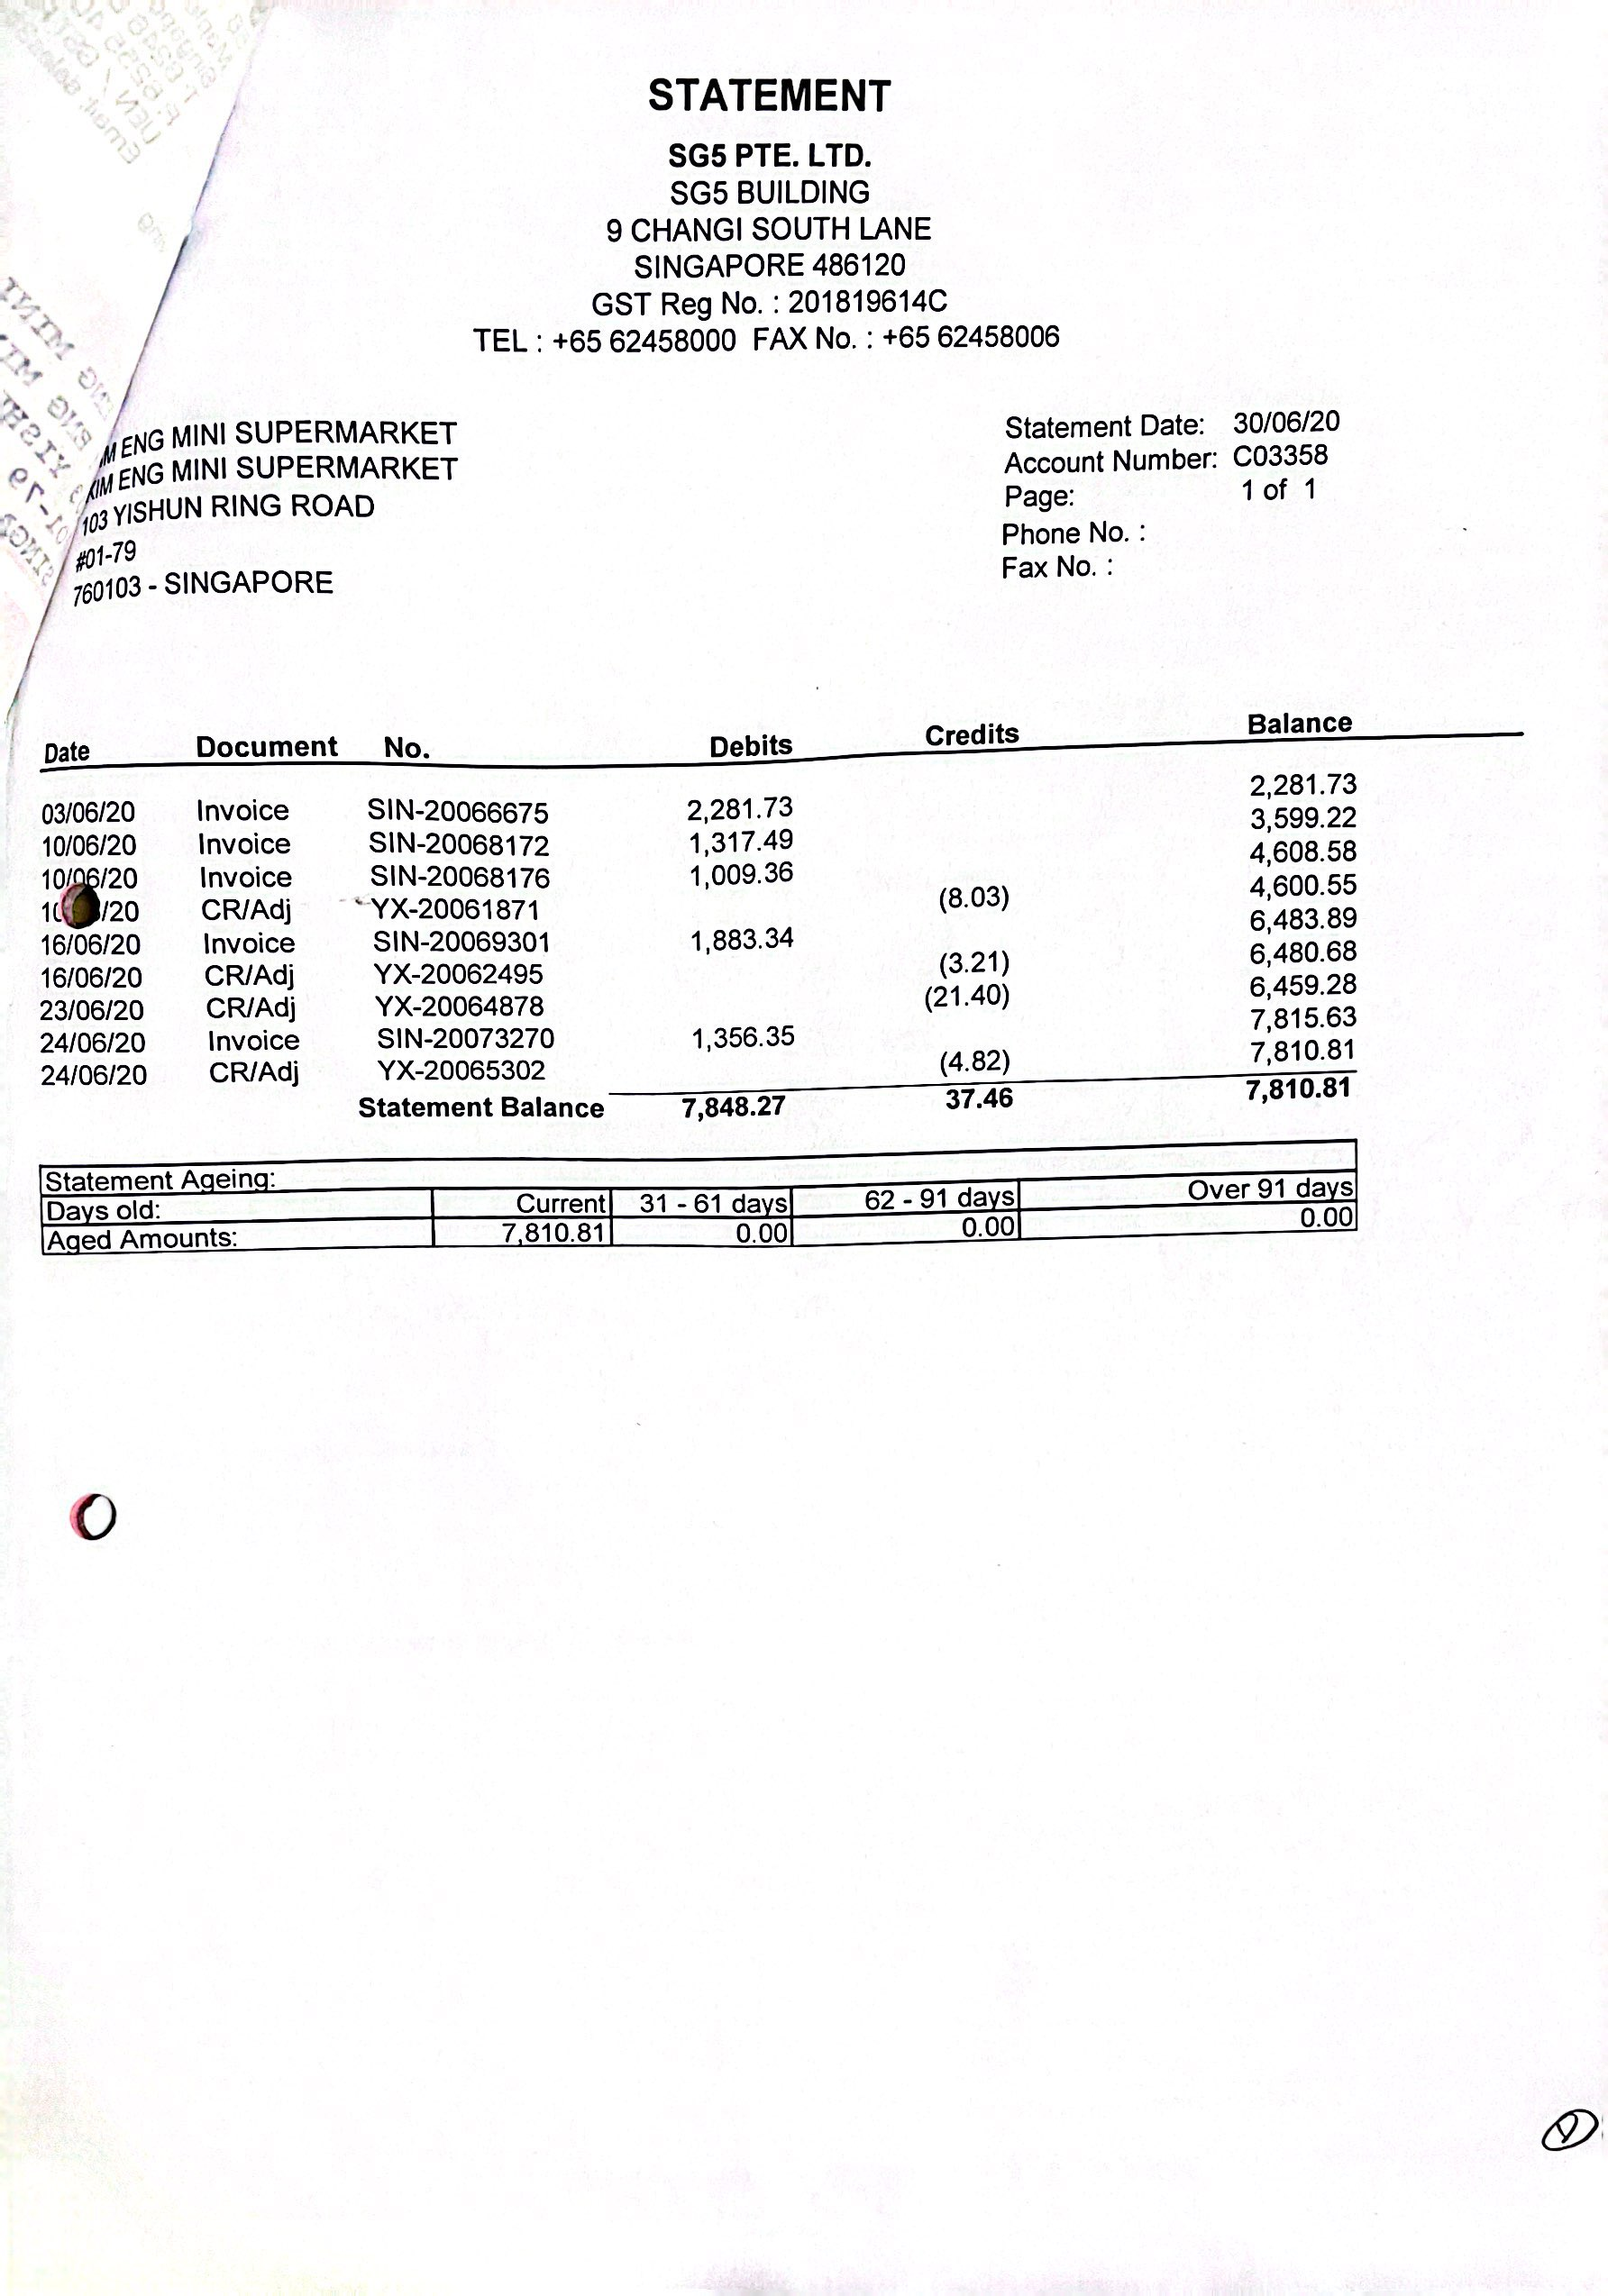

{
    "menu": [
        {
            "nm": "STATEMENT",
            "price": [
                {
                    "nm": "SGS BUIDDING"
                },
                {
                    "nm": "SGS BUIDDING"
                },
                {
                    "nm": "CHANGIS SOUTHLANE",
                    "cnt": "9"
                }
            ]
        },
        {
            "nm": "GST Reg No.: 2018/1961AC",
            "price": "TEL: +65 62458006"
        },
        {
            "nm": "TEL: +65 62458800 FAX No.: \ud64d\ucf69 \u0938\u094d\u091f\u0947\u091f \u0938\u094d\u091f\u0947\u091f Statement Date: 30/06/20"
        },
        {
            "nm": "ANEG MINI SUPERMARKET",
            "price": "C03358"
        },
        {
            "nm": "YISHUN RING ROAD",
            "price": "Page: 1 of 1"
        },
        {
            "nm": "#81-79",
            "price": "Phone No.:"
        },
        {
            "nm": "SINGAPORE Fax No.:"
        },
        {
       

In [20]:
import json

img_path = "../data/Invoice//CamScanner 06-20-2023 11.20_105.jpg"
# img_path = "../data/Invoice/R-4-34.jpg"
image = Image.open(img_path).convert("RGB")
display(image)
pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(

    pixel_values.to(device),

    decoder_input_ids=decoder_input_ids.to(device),

    max_length=model.decoder.config.max_position_embeddings,

    early_stopping=True,

    pad_token_id=processor.tokenizer.pad_token_id,

    eos_token_id=processor.tokenizer.eos_token_id,

    use_cache=True,

    num_beams=1,

    bad_words_ids=[[processor.tokenizer.unk_token_id]],

    return_dict_in_generate=True,

)

sequence = processor.batch_decode(outputs.sequences)[0]

sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")

sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token

res = processor.token2json(sequence)
# print(res)
indented_data = json.dumps(res, indent=4)
print(indented_data)